# Injection missteering: beam clone of operational BCMS (3bp) using single bunch with swapped skews settings

- hopefully this time with BPM logging on


In [109]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.10.10
Your IP is 172.17.0.3
2017-11-01 21:08:26
---


In [110]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 120 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/data/2017.10.10.11.33.02.913.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/data/2017.10.10.14.57.41.160.mat


## Load the data

In [111]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value',
                                                    'PI_KFA45.CCV.value'],verbose=False)

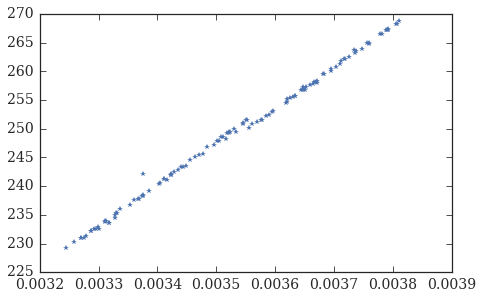

In [112]:
shiftVal=1
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')

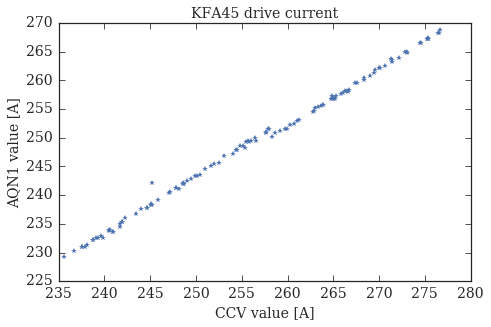

In [113]:
plt.plot(myDataFrame['PI_KFA45.CCV.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.title('KFA45 drive current')
plt.xlabel('CCV value [A]')
plt.ylabel('AQN1 value [A]')

## Measurement method:
This time the measurements are performed using a predefined array of random kicks.

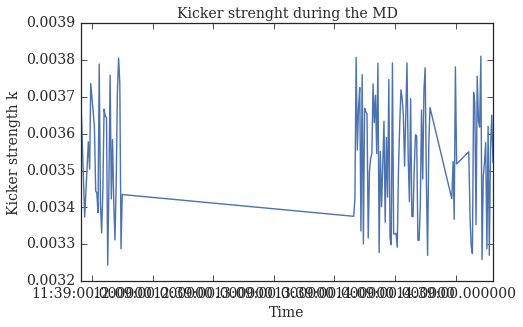

In [114]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal))
plt.xlabel('Time')
plt.ylabel('Kicker strength k')
plt.title('Kicker strenght during the MD')

## Intensity

In [115]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][105]/np.max(x) )

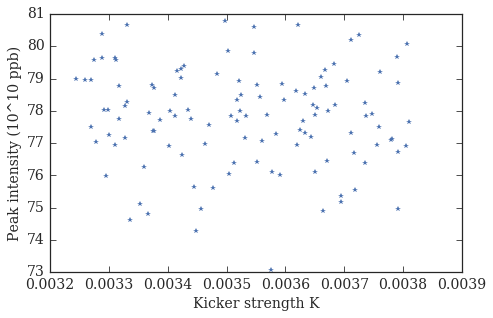

In [116]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

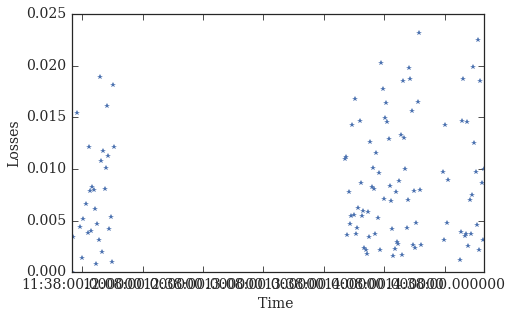

In [117]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

(0.0, 1500, -10.0, 90.0)

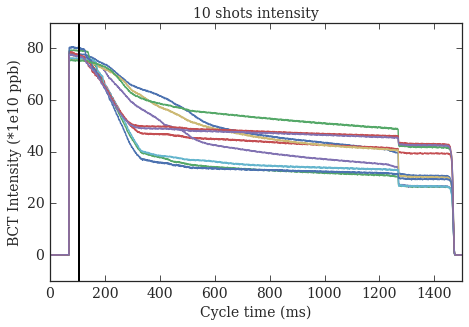

In [118]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=105, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,1500,y1,y2))

In [119]:
myDataFrame['Intensity'].values[100].max()

74.790140000000008

## BPMs

- for some reason, the second turn was not logged. The others are fine and the orbit as well. Boh ...

--> so no 1st-2nd turn difference possible

- the orbit deviation does not seem to be meaningful. 

In [120]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [121]:
## caluclate RMS orbit deviation and first two turns difference
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['OrbitX_dev_RMS'] = delta_1st_orbit

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['OrbitY_dev_RMS'] = delta_1st_orbit

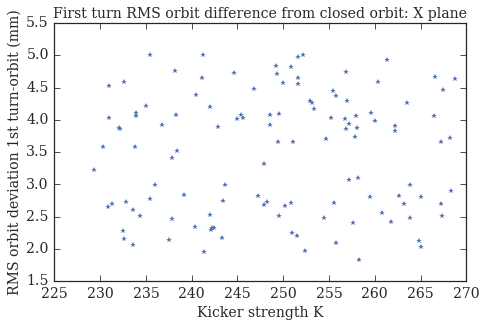

In [122]:
plt.plot(myDataFrame['PI_KFA45.AQN1.value'],myDataFrame['OrbitX_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: X plane')


x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,0,8))
#plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

(0.0032000000000000002, 0.0039000000000000003, 0.15, 0.3)

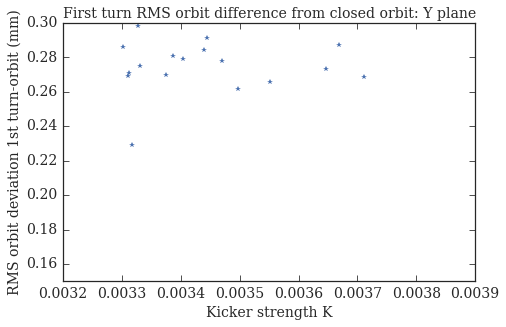

In [123]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.15,.3))
#plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [124]:
myDataFrame['BPMx_all_turns'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[20,:]/10.)
# myDataFrame['BPMy_all_turns'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[,:])


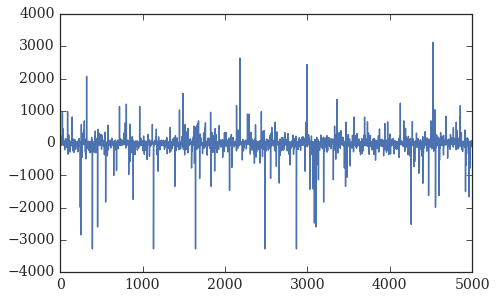

In [125]:
plt.plot(myDataFrame['BPMx_all_turns'].values[2])

In [126]:
myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].values[0]

array([[  -27,     0,   113, ...,  1082,  -399,  -379],
       [  -44,     0,    29, ...,  2323,     5, -1167],
       [  -17,     0,  -918, ...,  1187,   236,   -30],
       ..., 
       [    9,     0,   775, ...,  -385,  -620,  -521],
       [  -10,     0,   271, ...,   -62,  -773,  3813],
       [   -4,     0,   335, ...,  -551,  1414,     0]], dtype=int16)

## Wire scanner

### X plane

In [127]:
# Data cleanup
myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-10-10 11:37:07.900000'].name)

In [128]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [129]:
#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  

In [130]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

### Y plane

In [131]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [132]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [133]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

### Tomogram

In [134]:
myDataFrame['peakLineDensity'] = 1.22
myDataFrame['deltaP_P_rms'] = 8.34e-4

## Emitance

In [135]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.24577470 #at wirescanner 65
#     betax = 13.00860302 #at wirescanner 68
    betax = 21.77988929 #at wirescanner 65
    
    # --- MEASURED PARAMETERS
    D = 3.2 #at wirescanner 65
    betax = 20.11 #at wirescanner 65
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [136]:
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

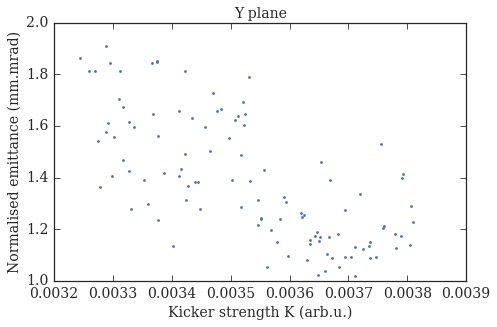

In [137]:
#bunched
Bunched_y, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.', label='Bunched')
plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')

plt.title('Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))

plt.show()

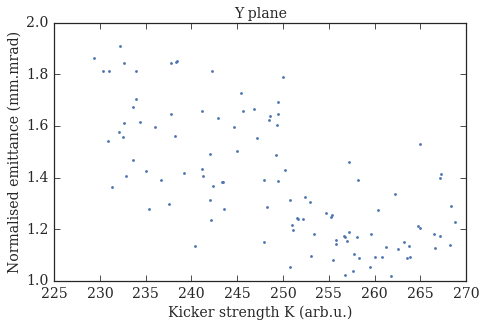

In [138]:
#bunched
Bunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'],myDataFrame['WS_emittance_y'],'.', label='Bunched')
plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')

plt.title('Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))

plt.show()

### X plane

In [139]:
myDataFrame['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],myDataFrame['deltaP_P_rms'].values[n])

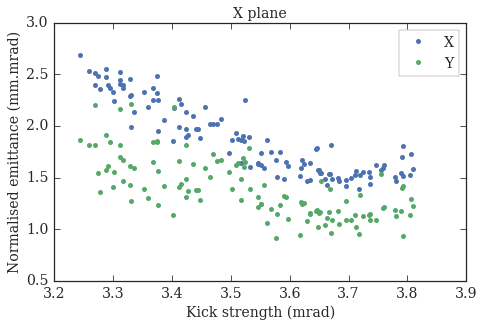

In [150]:
#bunched
fig, ax = plt.subplots(1)
ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.', label='X',markersize=10)
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.', label='Y',markersize=10)

plt.title('X plane')

plt.legend(frameon=True)



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))
plt.show()

fig.savefig('BCMS_n0_coupling_emi_xy.eps', format='eps')

## Comparison to theory

Model function: a(x - b)^2 + c
Fit params: a=3.81301021813 b= 0.00378116411851 c= 1.53630712087e-06


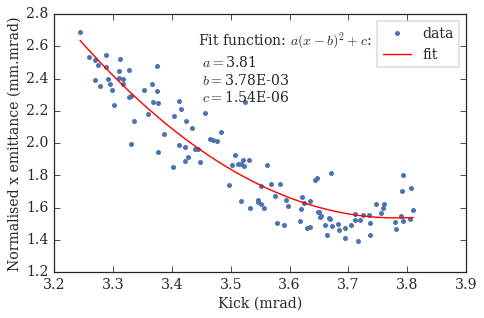

In [154]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_emittance_x'].values[1:]

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='data',markersize=10) #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)')
plt.ylabel('Normalised x emittance (mm.mrad)')
plt.legend(frameon=True)

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig.savefig('BCMS_no_coupling_emi_x_fitted.eps', format='eps')

## Laslett tune shift

In [142]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [143]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

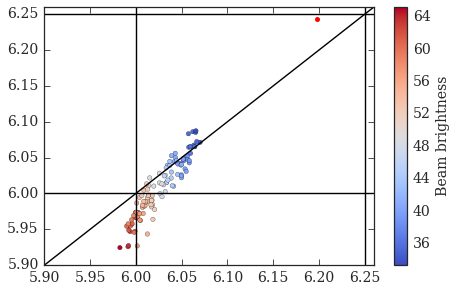

In [144]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.198
Qy = 6.244
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([5.9, 6.26])
plt.ylim([5.9, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

plt.show()

fig.savefig('BCMS_no_coupling_footprint.eps', format='eps')

Shifted x tune threshold < 6.198
Shifted y tune threshold < 6.244


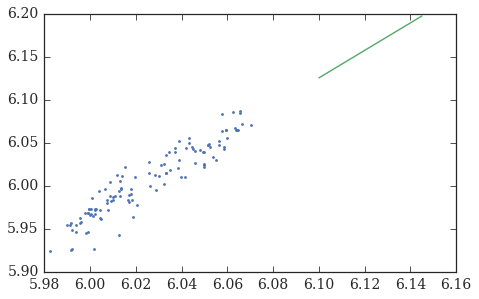

In [145]:
# linear fitting of the data
Qx_thr = -0
Qy_thr = -0
print 'Shifted x tune threshold < '+str(Qx+Qx_thr)
print 'Shifted y tune threshold < '+str(Qy+Qy_thr)

dQx = Qx + myDataFrame['deltaQx'].loc[(myDataFrame['deltaQx'] < Qx_thr) & (myDataFrame['deltaQy'] < Qy_thr)]
dQy = Qy + myDataFrame['deltaQy'].loc[(myDataFrame['deltaQx'] < Qx_thr) & (myDataFrame['deltaQy'] < Qy_thr)]
plt.plot(dQx,dQy,'.')

# the fit
param = np.polyfit(dQx,dQy,1)
x = np.linspace(6.1,6.145,100)
plt.plot(x,param[0]*x+param[1])


In [146]:
param

# print "multiplying by 4 it is: 4Qx - 4Qy = 1"

array([ 1.59821444, -3.62326178])

## Emittance with dispersive profile deconvolution calculation

In [94]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [95]:
# new tomogram analysis
files_tomo=sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/*.dat'))
tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_267.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_268.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_269.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_270.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_271.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_272.dat
/eos/project

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_318.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_319.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_320.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_321.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_322.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_323.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_369.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_370.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_371.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_372.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_373.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_374.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_420.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_421.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_422.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_423.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_424.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_425.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_471.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_472.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_473.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_474.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_475.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_476.dat
/eos/project/l/liu/Ins

In [103]:
timeTolerance = 4

# ----------
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str

succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d

            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

111/217 are within the timeTolerance
length of dataframe is: 119


In [104]:
# discard the elements without tomogram (are probably double shots of matlab)
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

In [105]:
### SLOW METHOD, processes twice
myDataFrame['momentumProfile']=myDataFrame['tomoFilename'].apply(extractProfile)

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_276.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_278.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_282.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_284.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_286.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_288.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_406.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_407.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_408.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_409.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_410.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/tomo_data/autosave_411.dat
/eos/project/l/liu/Ins

In [107]:
# BWS65
betax = 21.77988929
Dx = 3.24577470
betar = 0.915095
gammar = 2.47992305234

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile']['myProfile'],
                              row['momentumProfile']['deltaP_P'],
                              row['momentumProfile']['beta']*row['momentumProfile']['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


(1.2, 2.5, 1.2, 2.5)

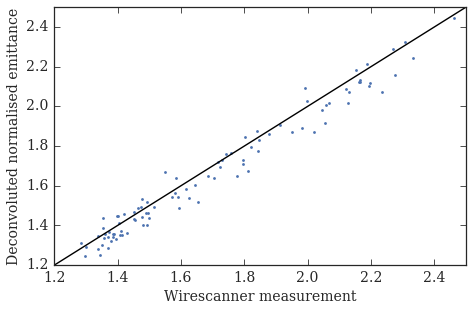

In [108]:
plt.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.')
plt.xlabel('Wirescanner measurement')
plt.ylabel('Deconvoluted normalised emittance')

plt.plot([1,3],[1,3],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((1.2,2.5,1.2,2.5))

## Export the data

In [ ]:
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[85])

In [ ]:
myDataFrame[['WS_intensity','logical_PI_KFA45.K.value','peakLineDensity','WS_emittance_x','WS_emittance_y','deltaP_P_rms']].to_csv('dataFrameExported.csv')